# Fraiser Dialog Speaker Classification

### On a Raspberry Pi 3 (DietPi Buster image)

Data Source: https://www.kaggle.com/sulabhbista/frasier-dialogs/data#script.csv

Columns:
- url: URL from where the dialog was downloaded
- cast: Name of the cast
- dialog: Dialog utterance by the cast
- timestamp: Date/time when the a specific row was downloaded

Tasks:
- Explore the text data
  - E.g. Check the top words used by each speaker
- Balance classes, if applicable
- Tokenise the data and train a classifier to predict the speaker
 - Use pre-trained word embedding
 - Use own word embedding

In [6]:
!pip3 install seaborn nltk

Looking in indexes: https://pypi.org/simple, https://www.piwheels.org/simple
    100% |████████████████████████████████| 1.5MB 192kB/s ta 0:00:01    12% |███▉                            | 174kB 534kB/s eta 0:00:03


In [7]:
import pandas as pd
import nltk
nltk.download('punkt')

import pickle

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [28]:
df = pd.read_csv('./script.csv')
df.head()

url     cast  \
0  http://www.kacl780.net/frasier/transcripts/sea...  Frasier   
1  http://www.kacl780.net/frasier/transcripts/sea...      Roz   
2  http://www.kacl780.net/frasier/transcripts/sea...  Frasier   
3  http://www.kacl780.net/frasier/transcripts/sea...  Russell   
4  http://www.kacl780.net/frasier/transcripts/sea...  Frasier   

                                              dialog            timestamp  
0  [firmly] Listen to yourself, Bob!  You follow ...  2018-04-13 07:43:16  
1  Yes, Dr Crane.  On line four, we have Russell ...  2018-04-13 07:43:16  
2  [presses a button] Hello, Russell.  This is Dr...  2018-04-13 07:43:16  
3  [v.o.] Well, I've been feeling sort of, uh, yo...  2018-04-13 07:43:16  
4  Er, Russell, we're just about at the end of ou...  2018-04-13 07:43:16

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63945 entries, 0 to 63944
Data columns (total 4 columns):
url          63945 non-null object
cast         63943 non-null object
dialog       63788 non-null object
timestamp    63945 non-null object
dtypes: object(4)
memory usage: 999.2+ KB


In [30]:
# dropping some unneeded columns

df.drop(columns=['url', 'timestamp'], inplace=True)
df.head()

cast                                             dialog
0  Frasier  [firmly] Listen to yourself, Bob!  You follow ...
1      Roz  Yes, Dr Crane.  On line four, we have Russell ...
2  Frasier  [presses a button] Hello, Russell.  This is Dr...
3  Russell  [v.o.] Well, I've been feeling sort of, uh, yo...
4  Frasier  Er, Russell, we're just about at the end of ou...

In [31]:
# cleaning some NaN columns
df.dropna(inplace=True)

In [32]:
df['cast'].unique()

array(['Frasier', 'Roz', 'Russell', ...,
       'Rachel: You can do me one quick favor',
       'leaving is because I want what all of you have now', 'Pilot'],
      dtype=object)

In [33]:
# some cast values contain dialog, let's focus on cast with top 5 value_counts

main_cast_counts = df['cast'].value_counts()[:5]
main_cast_counts

Frasier    21088
Niles      10178
Martin      7629
Daphne      5243
Roz         4735
Name: cast, dtype: int64

In [34]:
df_main = df.loc[df['cast'].isin(main_cast_counts.keys())]
df_main.head()

cast                                             dialog
0  Frasier  [firmly] Listen to yourself, Bob!  You follow ...
1      Roz  Yes, Dr Crane.  On line four, we have Russell ...
2  Frasier  [presses a button] Hello, Russell.  This is Dr...
4  Frasier  Er, Russell, we're just about at the end of ou...
5      Roz         No, we cut to the news thirty seconds ago.

## Data Exploration and Imbalance Checking

In [35]:
# There are 2x more Fraiser lines than the 2nd highest (Niles).
# Let's try to balance the dataset by sampling from the Fraiser rows
# Before we do that, let's see what the average dialog length is for Fraiser

In [36]:
tokenizer = nltk.tokenize.RegexpTokenizer(r'[\w\']+') # include aposptophes

tokens = df_main.loc[df_main['cast'] == 'Frasier', 'dialog'].apply(tokenizer.tokenize)
tokens

0        [firmly, Listen, to, yourself, Bob, You, follo...
2        [presses, a, button, Hello, Russell, This, is,...
4        [Er, Russell, we're, just, about, at, the, end...
6        [annoyed, rips, off, his, headphones, Oh, for,...
7        [Well, the, rest, of, the, show, was, pretty, ...
9        [Roz, in, the, trade, we, call, that, avoidanc...
11       [I, am, not, a, piece, of, Lalique, I, can, ha...
13       [takes, the, notepaper, You, say, my, brother,...
17       [looks, up, Oh, I'm, sorry, Niles, I, didn't, ...
19       [Oh, Niles, you're, a, psychiatrist, you, know...
21                                                   [And]
23       [Yes, I, know, what, you, think, about, everyt...
26                            [Two, cafe, latte, supremos]
27                                        [No, thank, you]
29       [I'm, fine, I, love, my, new, life, I, love, t...
31       [So, does, he, laughs, The, fresh, air's, good...
33                                           [Is, it, Da

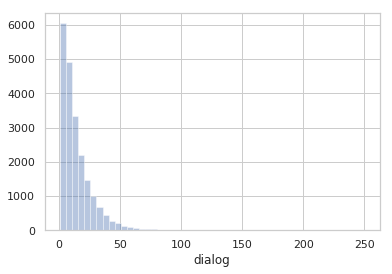

In [37]:
lengths = tokens.apply(len)
sns.distplot(lengths, kde=False)
plt.show()

In [38]:
lengths.describe()

count    21088.000000
mean        13.954097
std         13.583504
min          1.000000
25%          5.000000
50%         10.000000
75%         19.000000
max        250.000000
Name: dialog, dtype: float64

In [39]:
# capturing the above into a function
def plot_wordcount_distribution(cast, df_input):
    tokenizer = nltk.tokenize.RegexpTokenizer(r'[\w\']+') # include aposptophes
    tokens = df_input.loc[df_input['cast'] == cast, 'dialog'].apply(tokenizer.tokenize)
    lengths = tokens.apply(len)
    sns.distplot(lengths, kde=False)
    plt.xlabel(cast)
    plt.show()
    return lengths.describe()

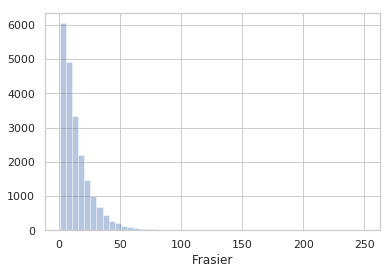

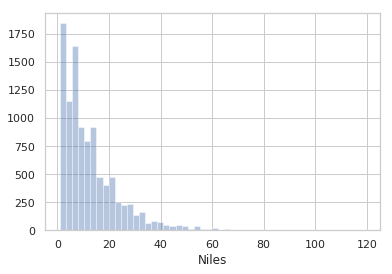

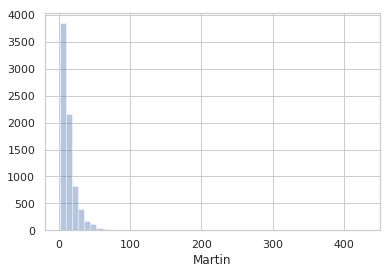

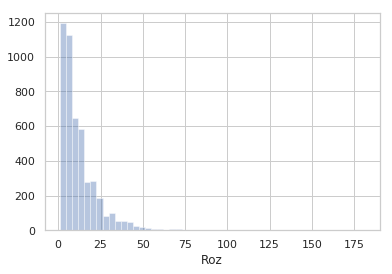

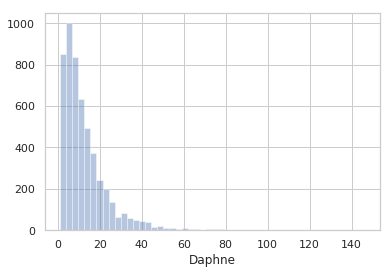

In [40]:
stats = pd.DataFrame({'Frasier': plot_wordcount_distribution('Frasier', df_main)})
stats = pd.concat([stats, pd.DataFrame({'Niles': plot_wordcount_distribution('Niles', df_main)})], axis=1) # col-wise concat
stats = pd.concat([stats, pd.DataFrame({'Martin': plot_wordcount_distribution('Martin', df_main)})], axis=1)
stats = pd.concat([stats, pd.DataFrame({'Roz': plot_wordcount_distribution('Roz', df_main)})], axis=1) 
stats = pd.concat([stats, pd.DataFrame({'Daphne': plot_wordcount_distribution('Daphne', df_main)})], axis=1)

In [41]:
# stats at a glance
stats

Frasier         Niles       Martin          Roz       Daphne
count  21088.000000  10178.000000  7629.000000  4735.000000  5243.000000
mean      13.954097     12.746512    12.874033    12.062302    12.732596
std       13.583504     11.720568    13.316791    11.796728    12.514220
min        1.000000      1.000000     1.000000     1.000000     1.000000
25%        5.000000      5.000000     5.000000     4.000000     5.000000
50%       10.000000      9.000000     9.000000     9.000000     9.000000
75%       19.000000     17.000000    17.000000    16.000000    16.000000
max      250.000000    119.000000   429.000000   181.000000   146.000000

In [42]:
# 75% percentile is about 18-29 tokens
# The distributions are quite similar, so we will undersample from Frasier to balance the classes a bit more
# They don't have to be exactly the same.

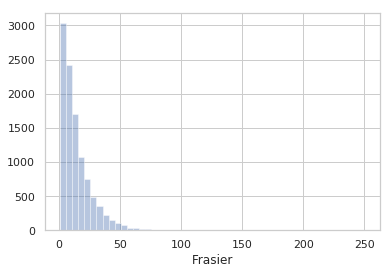

In [43]:
df_frasier_sampled = df_main.loc[df_main['cast'] == 'Frasier'].sample(frac=.5)

stats = pd.concat([stats, pd.DataFrame({'Frasier (sampled)': plot_wordcount_distribution('Frasier', df_frasier_sampled)})], axis=1)

In [44]:
# compare before and after undersampling.
stats

Frasier         Niles       Martin          Roz       Daphne  \
count  21088.000000  10178.000000  7629.000000  4735.000000  5243.000000   
mean      13.954097     12.746512    12.874033    12.062302    12.732596   
std       13.583504     11.720568    13.316791    11.796728    12.514220   
min        1.000000      1.000000     1.000000     1.000000     1.000000   
25%        5.000000      5.000000     5.000000     4.000000     5.000000   
50%       10.000000      9.000000     9.000000     9.000000     9.000000   
75%       19.000000     17.000000    17.000000    16.000000    16.000000   
max      250.000000    119.000000   429.000000   181.000000   146.000000   

       Frasier (sampled)  
count       10544.000000  
mean           13.995827  
std            13.708237  
min             1.000000  
25%             5.000000  
50%            10.000000  
75%            19.000000  
max           250.000000

In [45]:
# create our dataset
df_main_balanced = df_frasier_sampled

cast = ['Niles', 'Martin', 'Roz', 'Daphne']
for c in cast:
    df_main_balanced = pd.concat([df_main_balanced, 
                                  df_main.loc[df_main['cast'] == c]])

In [46]:
df_main_balanced['cast'].value_counts()

Frasier    10544
Niles      10178
Martin      7629
Daphne      5243
Roz         4735
Name: cast, dtype: int64

In [47]:
# save a snapshot of our balanced dataframe
pickle.dump(df_main_balanced, open('./df_main_balanced.pkl', 'wb'))

## Tokenisation and Model Engineering